## A cylindrical permanent magnet falling through a non-conducting pipe with a copper wire loop attached to the pipe (Phys 326, E&M)

A permanent magnet in the form of a cylinder is dropped at the top end of a vertical pipe. The pipe is non-conducting.
Its role is simply to restrain the motion of the magnet, therefore the radius of the pipe is close to the radius of
the magnet $a$. The pipe has a copper wire loop attached to it horizontally at a distance $z_\mathrm{wl}-z_0$ from its top, where $z_0$ and $z_\mathrm{wl}$ are z-coordinates (in a cyclindrical coordinate system) of pipe's top end and position of the wire loop. The $Z$ axis coincides with cylinder's axis and is directed downwards.
The wire loop has a cross-section diameter $d_\mathrm{wl}$, and its radius is equal to $r_\mathrm{wl}=a+0.5 d_\mathrm{wl}$, neglecting the thickness of pipe's wall. When the magnet approaches the wire loop, its magnetic field produces a changing magnetic flux through the surface area of the loop that generates electric current in the wire (Faraday's law). 

You are asked to build up a numerical model of this process and answer the following questions:
 
a) How does the electric current in the wire loop $I$ change with time?

b) How does the acceleration experienced by the magnet change with time?

Illustrate your answers with figures.

In [1]:
from __future__ import division
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy.integrate import dblquad, nquad, simps
from scipy import interpolate
from mpl_toolkits.mplot3d import axes3d
from time import time

fsize=20
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'

init_printing()

To compute the magnetic field components of the cylindrical magnet in the cylindrical coordinate system, you can use the following equations from http://demonstrations.wolfram.com/MagneticFieldOfACylindricalBarMagnet/:

$$
B_z = B_0\int_0^{2\pi}\int_0^a\left\{\frac{R(L/2-z)}{[R^2+(L/2-z)^2+r^2-2Rr\cos\phi]^{3/2}} + 
\frac{R(L/2+z)}{[R^2+(L/2+z)^2+r^2-2Rr\cos\phi]^{3/2}}\right\}dRd\phi
$$

and

$$
B_r = B_0\int_0^{2\pi}\int_0^a\left\{-\frac{R(r-R\cos\phi)}{[R^2+(L/2-z)^2+r^2-2Rr\cos\phi]^{3/2}} + 
\frac{R(r-R\cos\phi)}{[R^2+(L/2+z)^2+r^2-2Rr\cos\phi]^{3/2}}\right\}dRd\phi,
$$

where $(r,\phi,z)$ are the cylindrical coordinates, $B_0 = -\frac{\mu_0}{4\pi}M$, and $M$ is the magnetization of the cylinder.

### Parameters of the cylindrical magnet and wire loop in SI units

In [2]:
rho = 7400 # (kg/m**3) density of neodymium the magnet is assumed to be made of
M=1e6 # magnetization of the neodymium cylinder (in A/m)

a=0.01 # radius of the cylinder (in m)
L=0.002 # height of the cylinder (in m)

B0=-sc.mu_0/(4*np.pi)*M # this is the constant in the above equations

dwl = 0.001 # diameter (in m) of wire's cross section
rwl = a+0.5*dwl # radius (in m) of the wire loop through which the magnet is falling
rhom = 1.68e-8 # (Om*m) the resistivity of copper
z0 = 0. # initial z coordinate (in m) of the magnet over the wire loop
zwl = 0.2 # z coordinate (in m) of wire loop's position on the pipe

g = 9.80665 # (m/s**2) a standard gravity value

In [3]:
# These are the integrands from the above equations

def funcBz(phi, R):
    return (R*(0.5*L-z)/(R**2+(0.5*L-z)**2+r**2-2*R*r*np.cos(phi))**1.5+
        R*(0.5*L+z)/(R**2+(0.5*L+z)**2+r**2-2*R*r*np.cos(phi))**1.5)

def funcBr(phi, R):
    return (-R*(r-R*np.cos(phi))/(R**2+(0.5*L-z)**2+r**2-2*R*r*np.cos(phi))**1.5+
        R*(r-R*np.cos(phi))/(R**2+(0.5*L+z)**2+r**2-2*R*r*np.cos(phi))**1.5)

First, let us make a plot of our experiment projected on the (X,Z) plane in a Cartesian coordinate system.

In [4]:
# Cartesian coordinate grid for a projection of the magnetic field and pipe on the (X,Z) plane

la=4 # a half of the size of the plotted domain (cube) in units of a
L2=la*a # same in m
n=11 # number of mesh points along each of the coordinate axes

xx = np.linspace(-L2,L2,n)
#yy = np.linspace(-L2,L2,n) # yy is needed only for a 3d plot 
zz = np.linspace(-L2,L2,n)

# to plot a projection on the (X,Z) plane 
yy = np.linspace(0,0,n)

bx = np.zeros((n,n,n),dtype=float)
by = np.zeros((n,n,n),dtype=float)
bz = np.zeros((n,n,n),dtype=float)

In [5]:
# find z and r components of the magnetic field in the cylindrical coordiantes and transform them to
# x, y, and z components in the Cartesian coordinate system
# for this, we compute the above integrals using nquad or dblquad functions from scipy.integrate

t=time()

maxerz = 0.
maxfz = 0.
maxerr = 0.
maxfr = 0.

for i in range(n):
    x=xx[i]
    for j in range(n):
        y=yy[j]
        r=np.sqrt(x**2+y**2)
        alpha=np.arctan2(y,x)
        for k in range(n):
            z=zz[k];
            fz=nquad(funcBz, [[0,2*np.pi],[0, a]])
            fr=nquad(funcBr, [[0,2*np.pi],[0, a]])
            #fz=dblquad(funcBz, 0, a, lambda phi: 0, lambda phi: 2*np.pi)
            #fr=dblquad(funcBr, 0, a, lambda phi: 0, lambda phi: 2*np.pi)
            Br=B0*fr[0]         
            bx[i,j,k] = Br * (np.cos(alpha))            
            by[i,j,k] = Br * (np.sin(alpha))           
            bz[i,j,k] = B0*fz[0]
            
            # find maximum errors of the integration for the z and r components
            if abs(fz[0]) > 0. : 
                erz = abs(fz[1]/fz[0])
            else:
                erz = 0.
            if erz > maxerz:
                maxerz = erz
                maxfz = fz[0]
                
            if abs(fr[0]) > 0. : 
                err = abs(fr[1]/fr[0])
            else:
                err = 0.
            if err > maxerr:
                maxerr = err
                maxfr = fr[0]

xx,yy,zz = np.meshgrid(xx,yy,zz)

print (time()-t), "seconds"
print "maxerz = ",maxerz,", maxfz = ",maxfz
print "maxerr = ",maxerr,", maxfr = ",maxfr

15.7110188007 seconds
maxerz =  8.3814353957e-06 , maxfz =  0.000997684491889
maxerr =  144983.448949 , maxfr =  -1.3992572972e-19


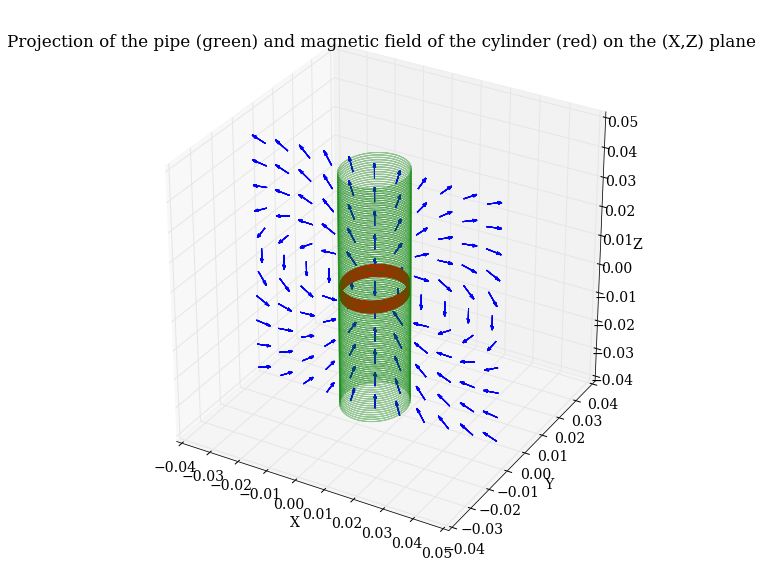

In [7]:
# 3d figure of the (X,Z) projection
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(10,10)                         

# or its projection on the (X,Z) plane
ax.quiver(xx,yy,zz,bx[:,5,:],by[:,5,:],bz[:,5,:],color='b',length=0.5*a,pivot='middle')

# Plot the magnetic cylinder surrounded by a pipe

def cylinder(r):
    beta = np.linspace(-2*np.pi,2*np.pi,100)
    x = r*np.cos(beta)
    y = r*np.sin(beta)
    return x,y

cx,cy = cylinder(a)
cx2,cy2 = cylinder(rwl)

for i in np.linspace(-L,L,100):                
    ax.plot(cx,cy,i,label='Cylinder',color='r',alpha=0.8)
    
for i in np.linspace(-L2,L2,100):                
    ax.plot(cx2,cy2,i,label='Pipe',color='g',alpha=0.4)

plt.title('Projection of the pipe (green) and magnetic field of the cylinder (red) on the (X,Z) plane')
ax.set_ylim([-la*a,la*a])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

First, we find the z component of the field in the vicinity of magnet's surface that is needed to compute the magnetic flux through the surface area of the wire loop and its rate of change.

From now on, the Z axis is chosen to be directed from the top end of the pipe downwards, in the direction of the gravitational acceleration $\mathbf{g}$, i.e. $\mathbf{g}=g\mathbf{e}_z$, therefore pipe's top end is at the bottom of the above plot or, in other words, the above plot should be looked at upside down.

In [8]:
# coordinate grid for the computation of field's z component

n=11 # number of mesh points on magnet's diameter [-a,a]
# for n=11 it takes ~140 seconds to compute the field

xx = np.linspace(-a,a,n)
yy = np.linspace(-a,a,n)

ll=20 # this is how far from magnet's surface, in the units of magnet's height L, the field needs to be computed

# here, z=0 corresponds to magnet's center, therefore its front surface is at z=0.5*L. However, we should 
# use zz[0] = (0.5+eps)*L with a positive eps << 1, otherwise the integrals will converge very slowly
zz = np.linspace(0.501*L,ll*L,n)  

bz = np.zeros((n,n,n),dtype=float) # these will be the values of field's z component at the mesh points

In [9]:
# compute the z component of the magnetic field above the front surface of the cylindrical magnet

t=time()

maxerz = 0.
maxfz = 0.

for i in range(n):
    x=xx[i]
    for j in range(n):
        y=yy[j]
        r=np.sqrt(x**2+y**2)
        alpha=np.arctan2(y,x)
        for k in range(n):
            z=zz[k];
            fz=nquad(funcBz, [[0,2*np.pi],[0, a]])
            #fz=dblquad(funcBz, 0, a, lambda phi: 0, lambda phi: 2*np.pi)
            bz[i,j,k] = B0*fz[0]
            
            # find maximum error of the integration for the z component
            if abs(fz[0]) > 0. : 
                erz = abs(fz[1]/fz[0])
            else:
                erz = 0.
            if erz > maxerz:
                maxerz = erz
                maxfz = fz[0]

print (time()-t), "seconds"
print "maxerz = ",maxerz,", maxfz = ",maxfz

135.343413115 seconds
maxerz =  0.010592999738 , maxfz =  -1.26748807057


Make a plot showing how the z component of the field depends on the Cartesian x coordinate at y=0 and how it changes with the distance from magnets's front surface $z-z_\mathrm{m}$. Compare the obtained shape of $B_z(x)$ with the examples shown at http://www.coolmagnetman.com/field01.htm.

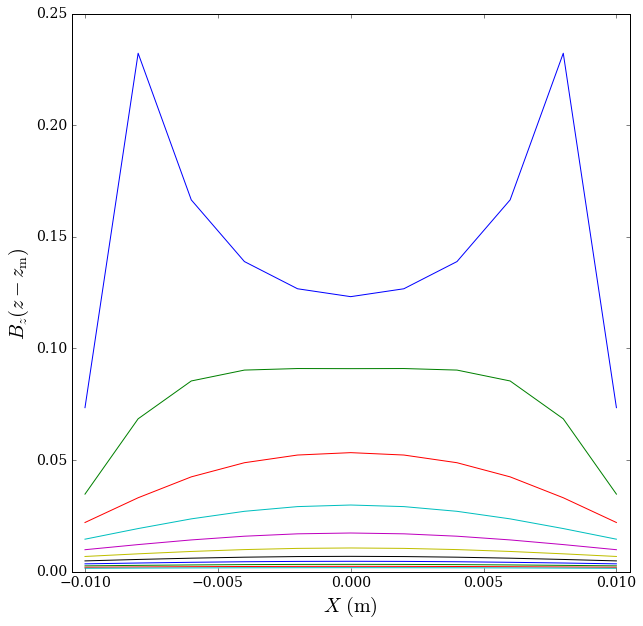

In [10]:
# z-zm is a distance from magnet's front surface

fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)

nm = int(n/2) # this value of the second index corresponds to y=0

for k in range(n):  # to plot the change of Bz with z
    plt.plot(xx,bz[:,nm,k])
ax.set_xlim([-rwl,rwl])
ax.set_xlabel('$X\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$B_z(z-z_\mathrm{m})$',fontsize=fsize)
plt.show()

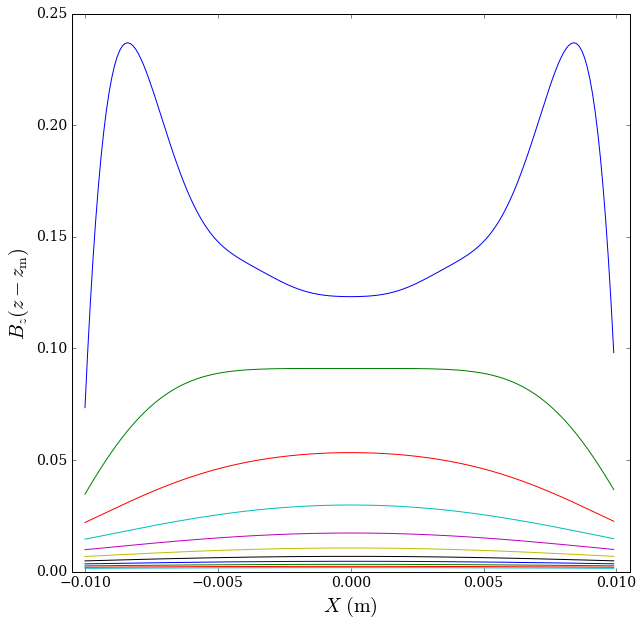

In [11]:
# To smooth the integration results, interpolate Bz in x and y, the latter coordinate being denoted z here

x1=xx; y1=zz; z1=(bz[:,nm,:]).transpose()
bz_int = interpolate.interp2d(x1, y1, z1, kind='quintic')  # use a scipy 2D interpolation 

fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
xnew = np.arange(-a, a, 1e-4)
ynew = np.linspace(0.5*L,ll*L,n)
znew = bz_int(xnew, ynew)
for k in range(n):
    plt.plot(xnew, znew[k, :])
ax.set_xlim([-rwl,rwl])
ax.set_xlabel('$X\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$B_z(z-z_\mathrm{m})$',fontsize=fsize)
plt.show()

Compute and plot the magnetic flux through the surface area of the wire loop $\Phi(z)=\int\mathbf{B}\cdot\mathbf{n}\,dA = \int_0^{r_\mathrm{wl}}2\pi x B_z(x)dx$ as a function of the distance from magnet's front surface.

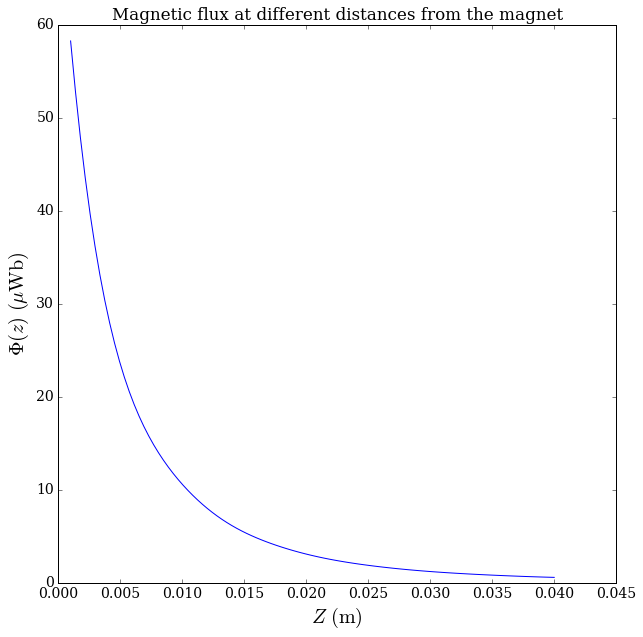

In [12]:
# compute and plot the magnetic flux as an integral over the surface area of the wire loop

n_int = 100 # number of mesh points for the integration

x_int = np.linspace(0,rwl,n_int)
y_int = np.linspace(0.5*L,ll*L,n_int) # these are mesh points along the Z axis at which the integral is computed

flux = np.linspace(0,0,n_int)

for k in range(n_int):
    f_int = 1e6*2*np.pi*x_int*bz_int(x_int,y_int[k])  # this is the integrand, where 1e6 expresses the flux in micro Wb
    flux[k] = simps(f_int, x=x_int) # e.g., use a simpson integration from scipy
    
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
plt.plot(y_int, flux)
ax.set_xlabel('$Z\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$\Phi(z)\ (\mu\mathrm{Wb})$',fontsize=fsize)
ax.set_title('Magnetic flux at different distances from the magnet')
plt.show()

To calculate the electromotive force (emf) later, we have to find the derivative of the magnetic flux with respect to the z coordinate $\frac{d\Phi}{dz}$. According to Faraday's law, the emf is $E = -\frac{d\Phi}{dt}$. In our case, it will be $E = -\frac{d\Phi}{dz}(z)\,v_z(t)$, where $v_z$ is the velocity of the magnet in the pipe. 

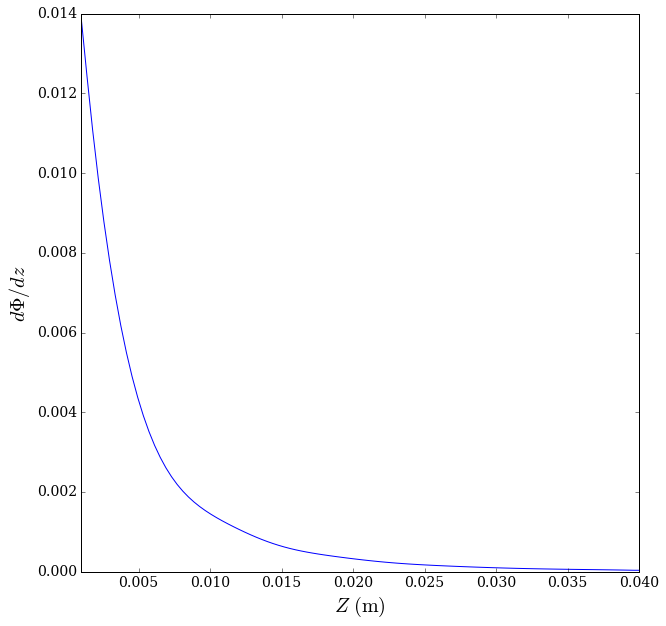

In [13]:
# emf is equal to a negative time derivative of the magnetic flux (Faraday's law) 
# first, we calculate and plot the derivative of the flux with respect to z

n_int1 = n_int-1
emf = np.linspace(0,0,n_int)

for k in range(n_int1):
    emf[k] = -1e-6*(flux[k+1]-flux[k])/(y_int[k+1]-y_int[k])  # 1e-6 transforms micro Wb back to Wb
emf[n_int1] = emf[n_int1-1]

fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
plt.plot(y_int,emf)
ax.set_xlim([0.5*L,ll*L])
ax.set_xlabel('$Z\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$d\Phi/dz$',fontsize=fsize)
plt.show()

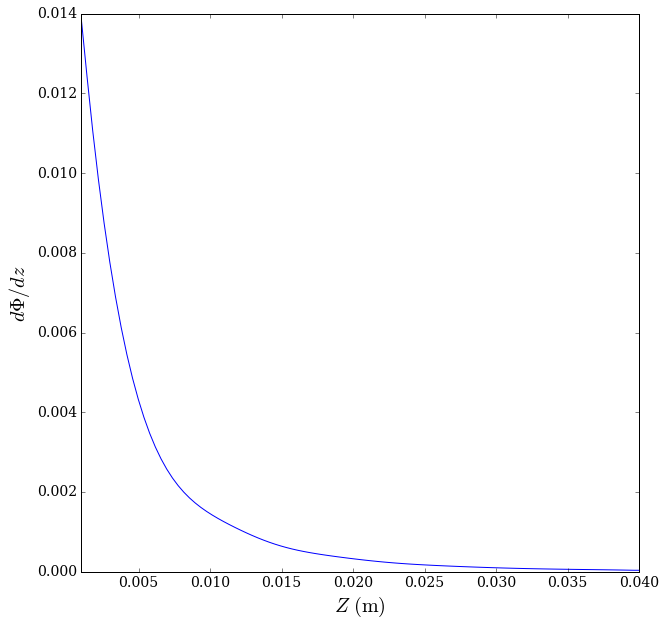

In [15]:
# To have at hand a function (emf_int) that allows us to calculate the derivative at any z between 0.5L and ll*L, 
# interpolate emf in y=z

y1=y_int[0:n_int]; z1=emf

emf_int = interpolate.interp1d(y1, z1)

fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
ynew = np.linspace(0.5*L,ll*L,n_int1)
znew = emf_int(ynew)
plt.plot(ynew, znew)
ax.set_xlim([0.5*L,ll*L])
ax.set_xlabel('$Z\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$d\Phi/dz$',fontsize=fsize)
plt.show()

As the magnet approaches the wire loop, it experiences action of the Lorentz force 
$$
F_z = \mathbf{F}\cdot\mathbf{e}_z = I\oint d\mathbf{l}\times\mathbf{B}\cdot\mathbf{e}_z = -2\pi r_\mathrm{wl} I B_r(x=r_\mathrm{wl},y=0,z),
$$
that decelerates its motion,
where $I=\frac{E}{R}$ is the current in the loop with a resistance $R$. According to Newton's third law, this force is equal by the magnitude, but opposite, to the force with which the magnet acts on the wire loop. We assume that the wire loop is fixed to the tube, otherwise it would begin to move alongside of the tube in the direction of magnet's motion. 

In [16]:
# coordinate grid for the computation of field's r component 

# it takes ~100 seconds to calculate the field

n=3 # we need to know the r component only at x=y=rwl
nz=1000 # we have to use a fine mesh in z, because field's z component changes rapidly with z

xx = np.linspace(-rwl,rwl,n)
yy = np.linspace(-rwl,rwl,n)
zz = np.linspace(0,ll*L,nz)

br = np.zeros((n,n,nz),dtype=float)

In [17]:
# compute the r-component of the magnetic field at the perimeter of the magnet, i.e. at x=y=rwl

t=time()

maxerr = 0.
maxfr = 0.

for i in range(n):
    x=xx[i]
    for j in range(n):
        y=yy[j]
        r=np.sqrt(x**2+y**2)
        alpha=np.arctan2(y,x)
        for k in range(nz):
            z=zz[k];
            fr=nquad(funcBr, [[0,2*np.pi],[0, a]])
            #fr=dblquad(funcBr, 0, a, lambda phi: 0, lambda phi: 2*np.pi)
            br[i,j,k] = B0*fr[0]
            
            # find maximum error of the integration for the r component
            if abs(fr[0]) > 0. : 
                err = abs(fr[1]/fr[0])
            else:
                err = 0.
            if err > maxerr:
                maxerr = err
                maxfr = fr[0]

print (time()-t), "seconds"
print "maxerr = ",maxerr,", maxfr = ",maxfr

99.5415360928 seconds
maxerr =  2282223.32234 , maxfr =  -4.09601424662e-21


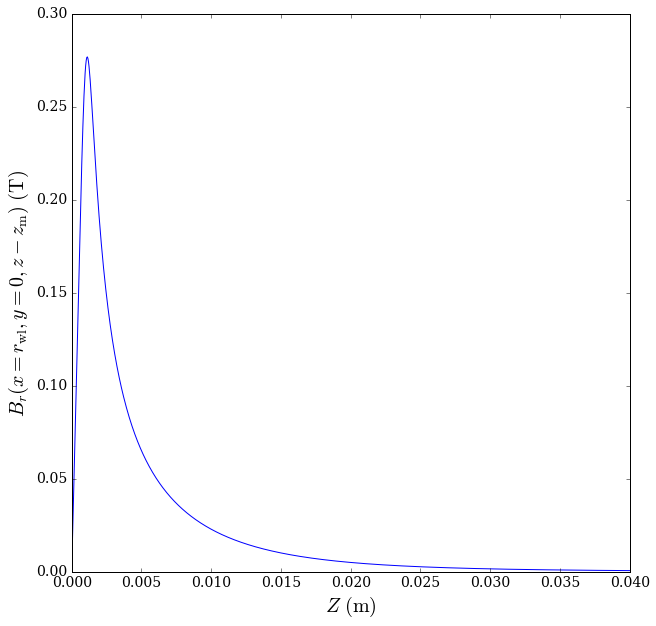

In [19]:
fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
nm = int(n/2)
plt.plot(zz,br[0,nm,:])
ax.set_xlim([0,ll*L])
ax.set_xlabel('$Z\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$B_r(x=r_\mathrm{wl},y=0,z-z_\mathrm{m})\ (\mathrm{T})$',fontsize=fsize)
plt.show()

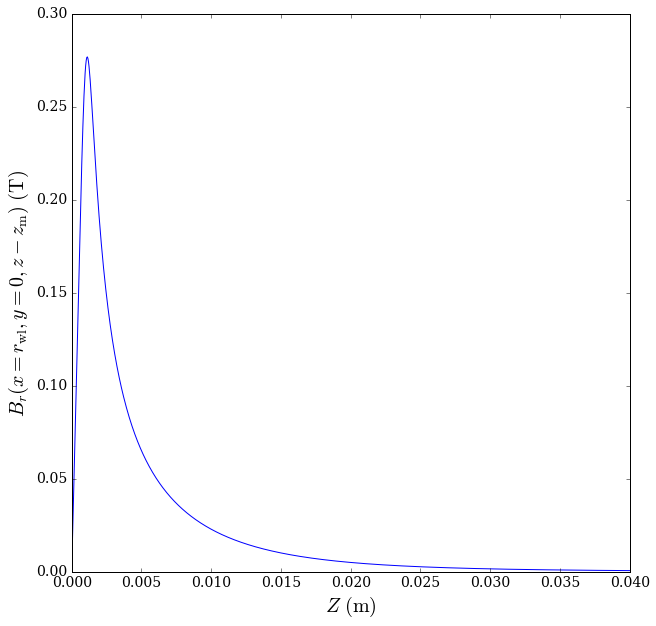

In [20]:
# To have at hand a function (br_int) that calculates Br at any z between 0.5L and ll*L, interpolate Br in x and y=z

x1=xx; y1=zz; z1=(br[:,nm,:]).transpose()
br_int = interpolate.interp2d(x1, y1, z1)

fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
xnew = rwl
ynew = np.linspace(0,ll*L,nz)
znew = br_int(xnew, ynew)
plt.plot(ynew, znew)
ax.set_xlim([0,ll*L])
ax.set_xlabel('$Z\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$B_r(x=r_\mathrm{wl},y=0,z-z_\mathrm{m})\ (\mathrm{T})$',fontsize=fsize)
plt.show()

In [21]:
# find the resistance of the copper wire loop Res and magnet's mass m

Res = 8*(rwl/dwl**2)*rhom
print "Res = ",Res,"(Om)"
m = (np.pi*a**2*L)*rho
print "m = ",m,"(kg)"

Res =  0.0014112 (Om)
m =  0.00464955712731 (kg)


Now, we are ready to integrate the equation of magnet's motion
$$
m\frac{dv_z}{dt} = mg + F_z.
$$

Because we have computed the magnetic field components only up to the distance $ll\cdot L$ from the magnet,
we assume that, after starting its motion at $z=z_0$, the magnet is initially in a free fall over the height 
$h=(z_\mathrm{wl}-ll\cdot L)-z_0$, 
before it will reach the distance $ll\cdot L$ from the wire loop located at $z=z_\mathrm{wl}$.

The right directions of the current and Lorentz force can be obtaind from Lenz's law.

In [24]:
nt = 1000000 # maximum number of integration time steps
nt1 = nt-1
ta = np.linspace(0,0,nt); za = np.linspace(0,0,nt); va = np.linspace(0,0,nt)
ca = np.linspace(0,0,nt); aratio = np.linspace(0,0,nt)

ll=19

dt0 = 0.000001 # the first time step

# Because we have computed the magnetic field components only up to the distance ll*L from the magnet,
# we assume that, after starting its motion at z=z0, the magnet is initially in a free fall over the height 
# h=(zwl-ll*L)-z0, before it will reach the distance ll*L from the wire loop at z=Zwl

z0 = 0. # this has been assumed as the initial position of the magnet
# alternatively, as a test, we can see what happens if the magnet starts its motion from 
# z0=zwl-ll*L

h = (zwl-z0)-ll*L # the magnet is in a free fall over this height before it will reach the vicinity of the
# wire loop for which we have computed the magnetic field components and flux

# after this free-fall time
t0 = np.sqrt(2*h/g) 
# the magnet will be at
zm0 = zwl-ll*L 
# and it will have the velocity
vm0 = np.sqrt(2*g*h); 

# we use these data as the initial conditions for the following integration:
i = 0 # time step number
ta[i]=t0 # time since the magnet's drop
za[i]=zm0 # magnet's vertical position
va[i] = vm0 # magnet's vertical velocity
am0 = g # magnet's acceleration
ca[i]=0 # current in the loop
aratio[i] = 0 # the ratio of magnet's acceleration to g

# the integration continues until the distance from the magnet to the loop is equal to 0.5*L

while(zwl-zm0 > 0.5*L and i < nt1):
    i = i+1
    current = emf_int(zwl-zm0)*vm0/Res # electric current in A
    amag = ((2*np.pi*rwl)/m)*current*br_int(rwl,zwl-zm0) # acceleration due to the Lorentz force
    am1 = g - amag
    aratio[i] = amag/g
    eps = 0.0001
    if np.abs(vm0) > 0:
        dt = eps*np.abs(vm0/g)
    else:
        dt = dt0
    vm1 = vm0 + 0.5*(am0+am1)*dt
    zm1 = zm0 + 0.5*(vm0+vm1)*dt
    am0 = am1; vm0 = vm1; zm0 = zm1; 
    ta[i] = ta[i-1]+dt; za[i] = zm1; va[i] = vm1
    ca[i] = current 

print i
print aratio[0:i]

1032
[  0.00000000e+00   5.70521994e-05   5.74332628e-05 ...,   7.30939459e+00
   7.37255513e+00   7.40695228e+00]


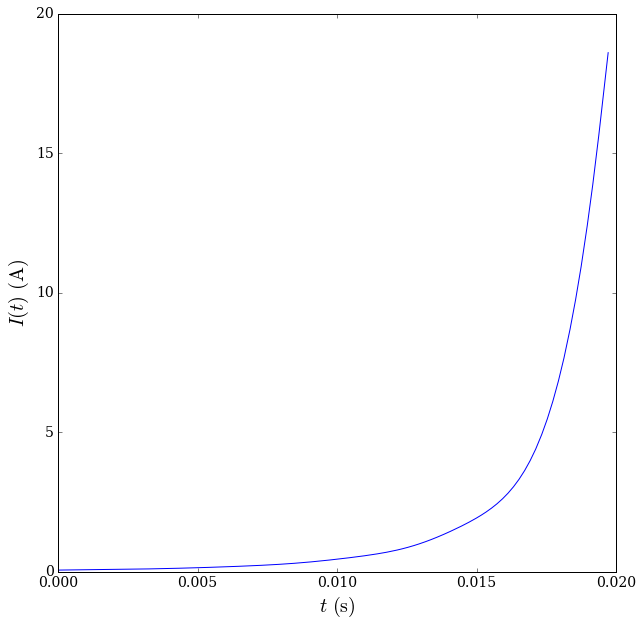

In [26]:
# plot the current

fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
plt.plot(ta[0:i]-ta[0], ca[0:i])
ax.set_xlabel('$t\ (\mathrm{s})$',fontsize=fsize)
ax.set_ylabel('$I(t)\ (\mathrm{A})$',fontsize=fsize)
plt.show()

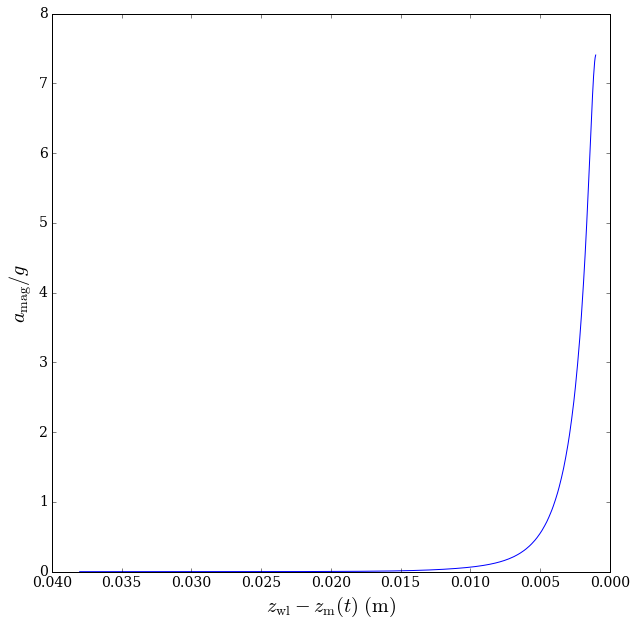

In [27]:
# plot the acceleration ratio

fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
plt.plot(zwl-za[0:i], aratio[0:i])
ax.invert_xaxis()
ax.set_xlabel('$z_\mathrm{wl}-z_\mathrm{m}(t)\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$a_\mathrm{mag}/g$',fontsize=fsize)
plt.show()

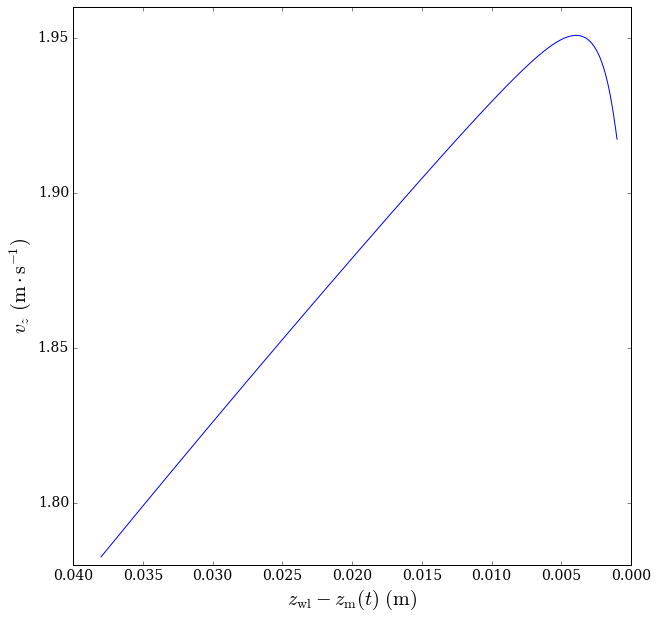

In [28]:
# plot magnet's velocity

fig=plt.figure()
ax=fig.gca()
fig.set_size_inches(10,10)
plt.plot(zwl-za[0:i], va[0:i])
ax.invert_xaxis()
ax.set_xlabel('$z_\mathrm{wl}-z_\mathrm{m}(t)\ (\mathrm{m})$',fontsize=fsize)
ax.set_ylabel('$v_z\ (\mathrm{m}\cdot\mathrm{s}^{-1})$',fontsize=fsize)
plt.show()